# HM1 algorithms and hyperparameters tuning

### RANDOM FOREST ALGORITHM

# Datasets

44 spam

1067 nasa

1464 blood-transfusion-service-center

40701 churn

### Libraries

In [1]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import openml
from skopt import BayesSearchCV

### Data input

In [2]:
dataset = {}
data = {}
labels = {}
id = [44,1067,1464,40701]
for index in id:
    dataset[index] = openml.datasets.get_dataset(index)
    data[index], y, _, _ = dataset[index].get_data(dataset_format="dataframe")
    data[index] = data[index].replace('nan', np.nan) # not always needed
    labels[index] = list(data[index].columns.values)

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Prog

### Preprocessing

In [3]:
def preprocess():
    num_pipeline = Pipeline(steps=[
        ('scale',MinMaxScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))

    ])

    col_trans = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, make_column_selector( dtype_exclude= np.object_)),
        ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_)),
        ],
    
        n_jobs=-1)
    
    model = Pipeline([('preprocessing', col_trans)])
    return model

In [4]:
data_prepared = {}
for index in id:
    datad = data[index]
    model =  preprocess()
    model.get_params()
    model.fit(datad)
    after_process = model.transform(datad)
    data_prepared[index] = pd.DataFrame(after_process, columns = labels[index])

### Data split

In [5]:
yColumnName = {44:"class",1067:"defects",1464:"Class",40701:"class"}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for index in id:

    X[index] = data_prepared[index].drop(yColumnName[index], axis=1)
    y[index] = data_prepared[index][yColumnName[index]]

    X_train[index],  X_test[index], y_train[index], y_test[index] = train_test_split(X[index], y[index])

## Grid search for tuning hyperparams

### RandomForestClassifier

In [6]:
pipeline = Pipeline([('RandomForestClassifier', RandomForestClassifier())])

In [7]:
pipeline.get_params()

{'memory': None,
 'steps': [('RandomForestClassifier', RandomForestClassifier())],
 'verbose': False,
 'RandomForestClassifier': RandomForestClassifier(),
 'RandomForestClassifier__bootstrap': True,
 'RandomForestClassifier__ccp_alpha': 0.0,
 'RandomForestClassifier__class_weight': None,
 'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': None,
 'RandomForestClassifier__max_features': 'sqrt',
 'RandomForestClassifier__max_leaf_nodes': None,
 'RandomForestClassifier__max_samples': None,
 'RandomForestClassifier__min_impurity_decrease': 0.0,
 'RandomForestClassifier__min_samples_leaf': 1,
 'RandomForestClassifier__min_samples_split': 2,
 'RandomForestClassifier__min_weight_fraction_leaf': 0.0,
 'RandomForestClassifier__n_estimators': 100,
 'RandomForestClassifier__n_jobs': None,
 'RandomForestClassifier__oob_score': False,
 'RandomForestClassifier__random_state': None,
 'RandomForestClassifier__verbose': 0,
 'RandomForestClassifier__warm_start': False}

In [8]:
n_estimators_vector = np.linspace(10, 200, 10).astype(np.int_)
min_samples_leaf_vector = np.linspace(1, 50, 5).astype(np.int_)
random_state_vector = np.array([1]).astype(np.int_)
max_depth_vector =  np.linspace(10, 110, 11).astype(np.int_)
min_samples_split_vector = np.linspace(2, 10, 4).astype(np.int_)

In [9]:
grid_params = [{'RandomForestClassifier__n_estimators':n_estimators_vector,
                'RandomForestClassifier__min_samples_leaf':min_samples_leaf_vector,
                'RandomForestClassifier__random_state': random_state_vector, 
                'RandomForestClassifier__max_depth': max_depth_vector,
                'RandomForestClassifier__min_samples_split': min_samples_split_vector
                }]

In [10]:
best_hyperparams = []
score_for_best_hyperparams = {}
std_scores = []
all_scores = {}

for index in id:
    gs_model_pipeline = RandomizedSearchCV(estimator=pipeline,param_distributions=grid_params,scoring='roc_auc',cv=2, n_iter=50, random_state=1)
    gs_model_pipeline.fit(X[index], y[index])
    best_hyperparams.append(gs_model_pipeline.best_params_)

    #score for test data
    std_scores.append(gs_model_pipeline.cv_results_['mean_test_score'])
    all_scores[index] = gs_model_pipeline.cv_results_['mean_test_score']


# Plots for RandomizedSearchCV()

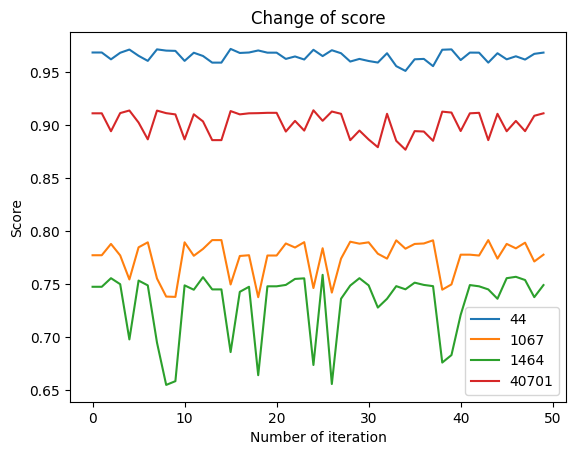

In [33]:
import matplotlib.pyplot as plt

for index in id:
    plt.plot(all_scores[index], label= index)
plt.title('Change of score')
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.legend(loc='lower right')

In [94]:
def plot_r(index):
    Y_maxining = []
    max = 0
    for z in all_scores[index]: 
        if(z>max):
            max = z
        Y_maxining.append(max)

    plt.plot(Y_maxining)
    plt.plot( Y_maxining, 'o')
    plt.title('Change of score for dataset' )
    plt.xlabel('Number of iteration')
    plt.ylabel('Score')

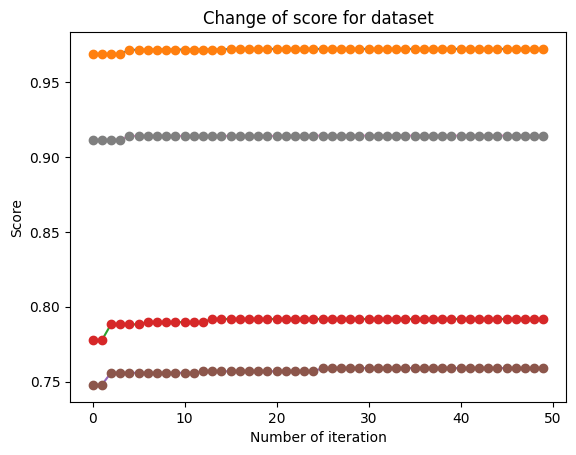

In [95]:
plot_r(44)
plot_r(1067)
plot_r(1464)
plot_r(40701)

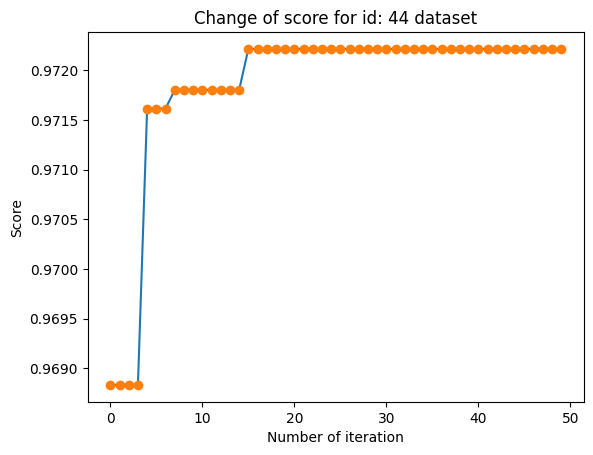

In [65]:
plot_r(44)

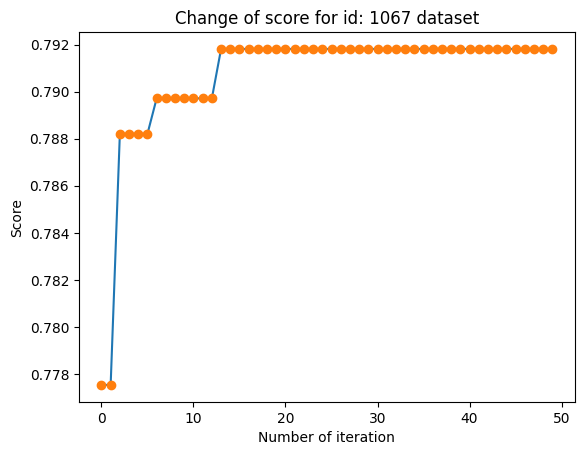

In [66]:
plot_r(1067)

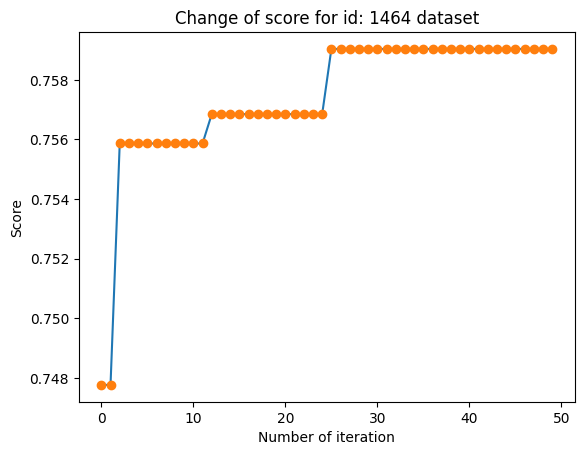

In [67]:
plot_r(1464)

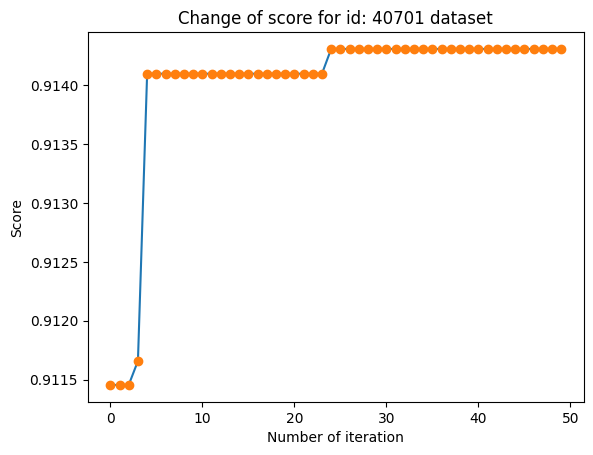

In [68]:
plot_r(40701)

# Default params

In [12]:
mean_std_vector   = np.mean(std_scores, axis =0)
minimum_std = np.max(mean_std_vector)
index_best = np.where(mean_std_vector == (minimum_std))[0][0]

In [13]:
for index in id:
    score_for_best_hyperparams[index] = np.max(all_scores[index])

In [14]:
score_for_best_hyperparams

{44: 0.972212816645488,
 1067: 0.7918185970316015,
 1464: 0.7590380445495762,
 40701: 0.9143081084977638}

In [15]:
defaults = gs_model_pipeline.cv_results_['params'][index_best]

### Diff for defaults - best params for each dataset from RandomizedSearch()

In [16]:
score_for_default_hyperparams = {}
diff = {}

for index in id:
    diff[index] = score_for_best_hyperparams[index] - all_scores[index][index_best]
diff

{44: 0.006767224362471347,
 1067: 0.007671359327067417,
 1464: 0.0,
 40701: 0.009916276045028316}

# Bayes Optimization

## BayesSearchCV

In [17]:
# number of iters to change
iters = 50

bayes_params = grid_params
best_hyperparams_bayes = []
all_scores_bayes = {}

for index in id:
    opt = BayesSearchCV(estimator=pipeline,search_spaces=bayes_params,scoring='roc_auc',cv=2, n_iter=iters, random_state=0)
    opt.fit(X[index], y[index])
    best_hyperparams_bayes.append(opt.best_params_)

    all_scores_bayes[index] = opt.cv_results_['mean_test_score']

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


# Plots for  BayesSearchCV()

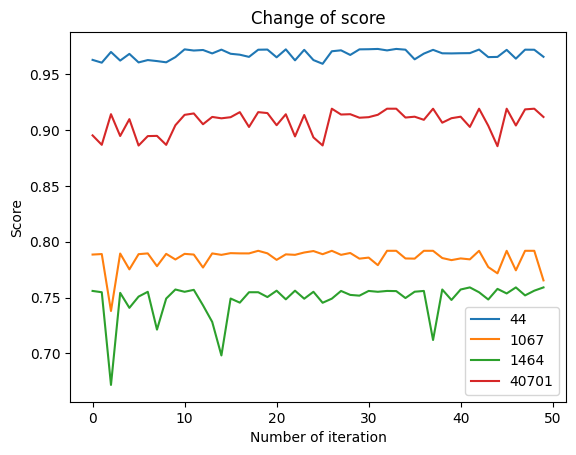

In [31]:
import matplotlib.pyplot as plt

for index in id:
    plt.plot(all_scores_bayes[index], label= index)
plt.title('Change of score')
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.legend(loc='lower right')

In [92]:
def plot_(index):
    Y_maxining = []
    max = 0
    for z in all_scores_bayes[index]: 
        if(z>max):
            max = z
        Y_maxining.append(max)

    plt.plot(Y_maxining)
    plt.plot( Y_maxining, 'o')
    plt.title('Change of score for dataset' )
    plt.xlabel('Number of iteration')
    plt.ylabel('Score')

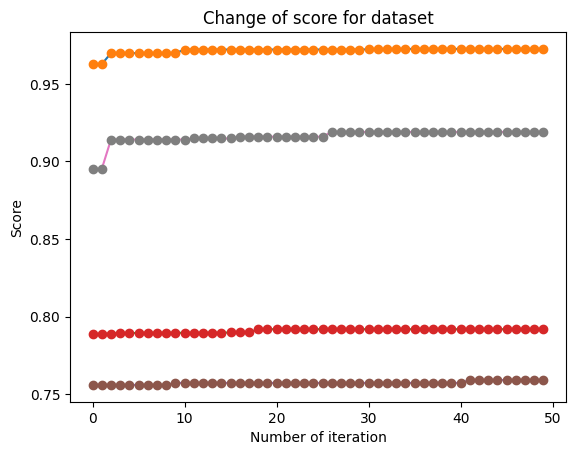

In [93]:
plot_(44)
plot_(1067)
plot_(1464)
plot_(40701)

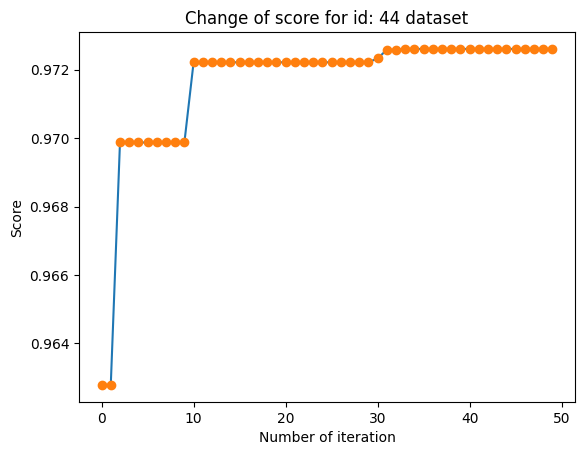

In [72]:
plot_(44)

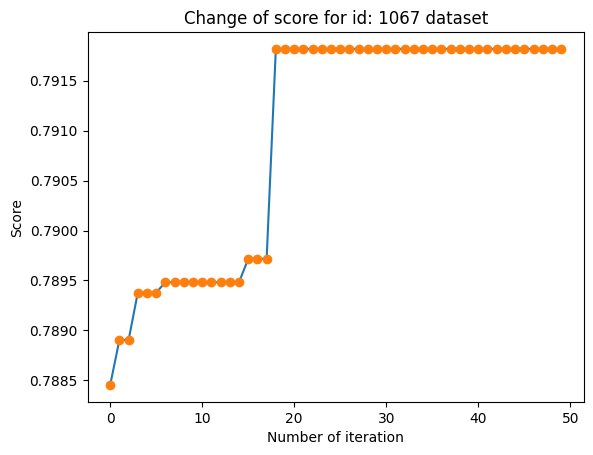

In [73]:
plot_(1067)

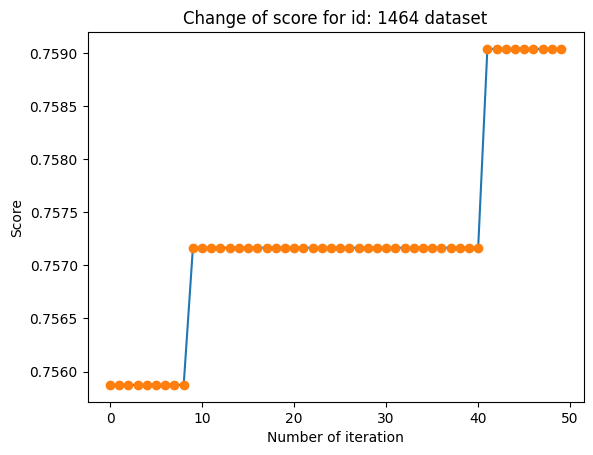

In [74]:
plot_(1464)

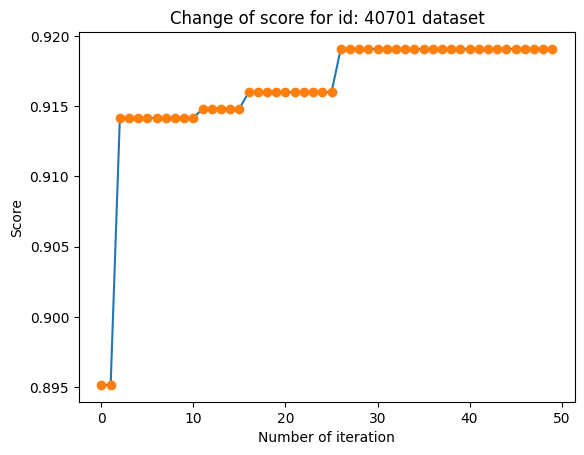

In [75]:
plot_(40701)

# Boxplots

Text(0.5, 1.0, 'Randomized Search - Random Forest')

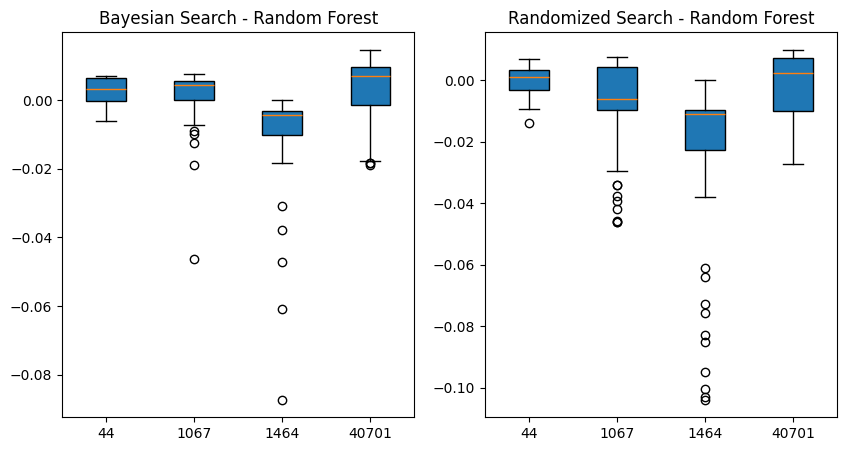

In [91]:
arrB = []
for index in id:
    arrB.append(all_scores_bayes[index] - all_scores[index][index_best])

arr = []
for index in id:
    arr.append(all_scores[index] - all_scores[index][index_best])


labels = id

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


bplot1 = ax1.boxplot(arrB,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Bayesian Search - Random Forest')


bplot1 = ax2.boxplot(arr,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Randomized Search - Random Forest')